# Traffic Sign Detection using Convolutional Neural Networks (CNN)

### Importing the required Modules and specifing the extensions

In [0]:
# Dataset Can be downloaded using the specified link
# https://bitbucket.org/jadslim/german-traffic-signs

In [0]:
# Specifing Tensorflow Version 2.x
%tensorflow_version 2.x

# Loading the Tensorboard Notebook Extension
%load_ext tensorboard

# Remove any logs from previous tensorboard runs
# !rm -rf ./logs/

In [0]:
# Importing the required Modules

# For Changing Working Directories
import os
from google.colab import drive

# For Image Processing
import cv2

# For Unpickling datasets
import pickle

# For Data Wrangling
import numpy as np
import pandas as pd
import random
from statistics import mean, median
from tensorflow.keras.utils import to_categorical

# For CNN Model
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Changing the current working directory
os.chdir("drive/My Drive/Colab Notebooks/Traffic Signs Classifier")

In [6]:
# Checking the current working directory
!pwd

/content/drive/My Drive/Colab Notebooks/Traffic Signs Classifier


### Loading the datasets

In [0]:
# Function for Loading the training, Validation, testing dataset
def load_data(training_file, validation_file, testing_file):
  
  with open(training_file, mode = "rb") as f:
    train = pickle.load(f)

  with open(validation_file, mode = "rb") as f:
    valid = pickle.load(f)

  with open(testing_file, mode = "rb") as f:
    test = pickle.load(f)

  return train, valid, test

In [0]:
# Loading the metadata for various traffic sign classes
data = pd.read_csv("traffic_signs.csv")

In [9]:
data.head()

ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

In [0]:
# Loading the training, Validation, testing dataset
train_data, valid_data, test_data = load_data("train.p", "valid.p", "test.p")

In [11]:
# Printing for checking the contents in the data
train_data

{'coords': array([[  6,   5,  21,  20],
        [  6,   6,  22,  22],
        [  5,   6,  22,  23],
        ...,
        [ 17,  15, 178, 155],
        [ 17,  15, 183, 160],
        [ 20,  18, 211, 184]], dtype=uint8),
 'features': array([[[[ 28,  25,  24],
          [ 27,  24,  23],
          [ 27,  24,  22],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  25],
          [ 31,  27,  26]],
 
         [[ 29,  26,  25],
          [ 27,  25,  23],
          [ 27,  25,  23],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  24],
          [ 30,  27,  25]],
 
         [[ 28,  26,  26],
          [ 27,  25,  23],
          [ 26,  25,  23],
          ...,
          [ 32,  28,  24],
          [ 31,  27,  24],
          [ 30,  27,  25]],
 
         ...,
 
         [[ 27,  24,  23],
          [ 28,  25,  24],
          [ 30,  25,  24],
          ...,
          [ 27,  24,  23],
          [ 28,  24,  22],
          [ 29,  25,  22]],
 
         [[ 28,  23,  23],
       

In [0]:
# Splitting Features and Labels
x_train, y_train = train_data["features"], train_data["labels"]
x_val, y_val = valid_data["features"], valid_data["labels"]
x_test, y_test = test_data["features"], test_data["labels"]

In [0]:
# Assertions for checking the datasets
assert x_train.shape[0] == y_train.shape[0], "Number of Training images and Training labels are not matching, Please Check the Training dataset"
assert x_train.shape[1:] == (32, 32, 3), "Number of Dimensions is not matching in the Training dataset"

assert x_val.shape[0] == y_val.shape[0], "Number of Validation images and Training labels are not matching, Please Check the Validation dataset"
assert x_val.shape[1:] == (32, 32, 3), "Number of Dimensions is not matching in the Validation dataset"

assert x_test.shape[0] == y_test.shape[0], "Number of Testing images and Training labels are not matching, Please Check the Testing dataset"
assert x_test.shape[1:] == (32, 32, 3), "Number of Dimensions is not matching in the Testing dataset"

In [0]:
# Global Variables
n_classes = np.unique(y_train).shape[0]
n_train = x_train.shape[0]
n_val = x_val.shape[0]
n_test = x_test.shape[0]

In [15]:
# Printing the number of images and classes
print("Number of Training Images = ", n_train)
print("Number of Validation Images = ", n_val)
print("Number of Testing Images = ", n_test)
print("Number of classes = ", n_classes)

Number of Training Images =  34799
Number of Validation Images =  4410
Number of Testing Images =  12630
Number of classes =  43


In [16]:
# Printing the Dimensions of images
print("Dimensions of Training Images = ", x_train.shape[1:])
print("Dimensions of Validation Images = ", x_val.shape[1:])
print("Dimensions of Testing Images = ", x_test.shape[1:])

Dimensions of Training Images =  (32, 32, 3)
Dimensions of Validation Images =  (32, 32, 3)
Dimensions of Testing Images =  (32, 32, 3)


### Visualizing the datasets

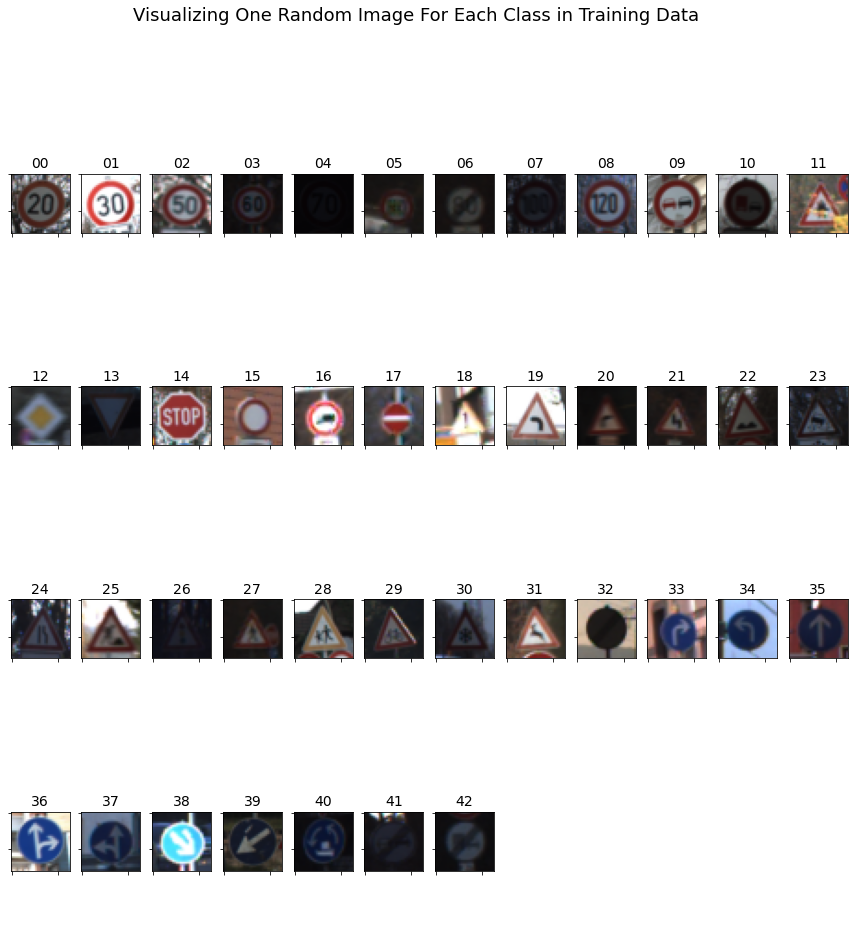

In [17]:
# Visualizing Random Samples from the dataset

def randomly_visualize_dataset(x_data, y_data, dataset):
  rows, cols = 4, 12
  fig, axis_array = plt.subplots(rows, cols, figsize = (15, 15))
  plt.suptitle(f"Visualizing One Random Image For Each Class in {dataset}", size = 18)

  for class_idx, ax in enumerate(axis_array.ravel()):
    if class_idx < n_classes:
      x = x_data[y_data == class_idx]
      img = x[np.random.randint(len(x))]
      ax.imshow(img)
      ax.set_title("{:02d}".format(class_idx), fontsize = 14)
    else:
      ax.axis("off")
    
  plt.setp([a.get_xticklabels() for a in axis_array.ravel()], visible = False)
  plt.setp([a.get_yticklabels() for a in axis_array.ravel()], visible = False)
  plt.draw()

randomly_visualize_dataset(x_train, y_train, dataset = "Training Data")

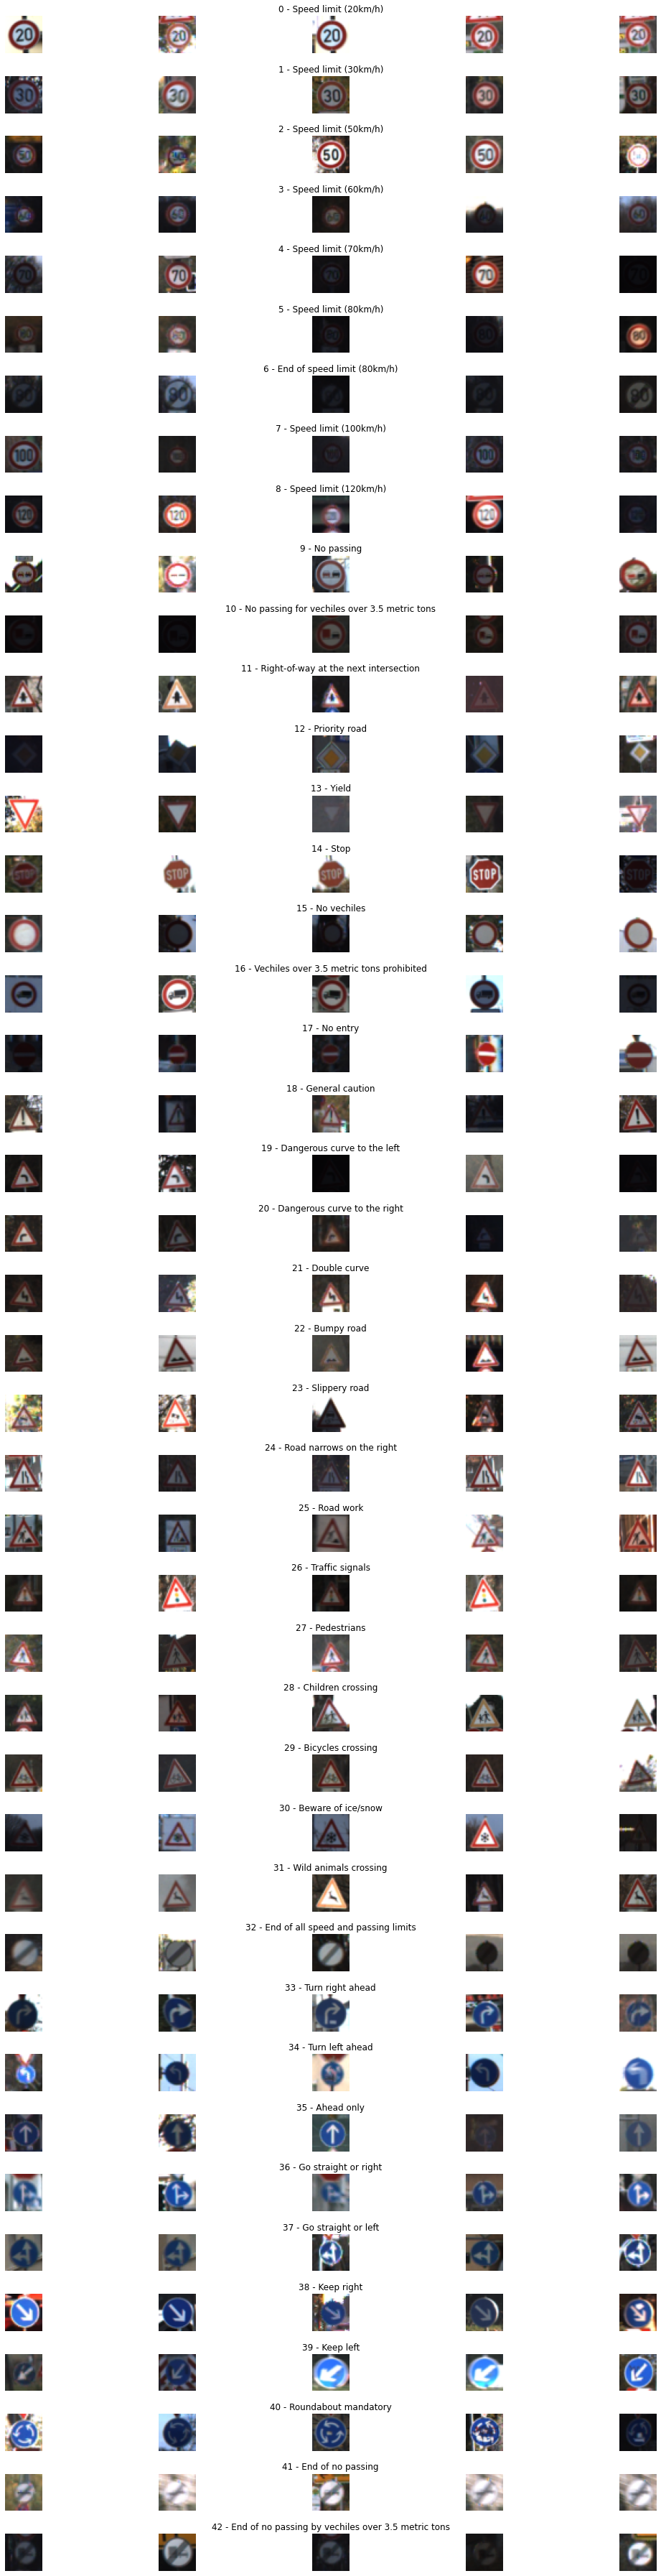

In [18]:
# Visualizing 5 images per class
n_samples = []

cols = 5
rows = n_classes

fig, axis = plt.subplots(nrows = rows, ncols = cols, figsize = (15, 50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x = x_train[y_train == j]
    axis[j][i].imshow(x[random.randint(0, (len(x) - 1)), :, :], cmap = "gray")
    axis[j][i].axis("off")

    if i == 2:
      axis[j][i].set_title(str(j) + ' - ' + row["SignName"])
      n_samples.append(len(x))

plt.show()

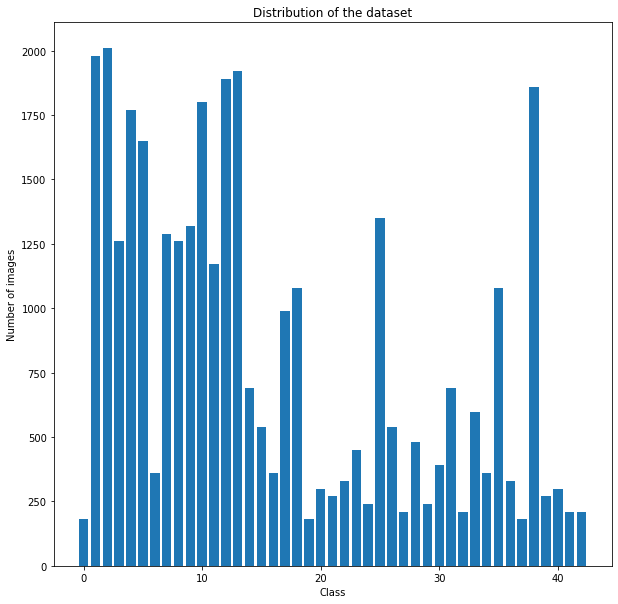

In [19]:
# Distribution of the dataset
plt.figure(figsize = (10, 10))
plt.bar(range(n_classes), n_samples)
plt.title("Distribution of the dataset")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

Dataset Training contains 34799 samples
Mean = 2.33% Median = 1.55%
Dataset Validation contains 4410 samples
Mean = 2.33% Median = 1.36%


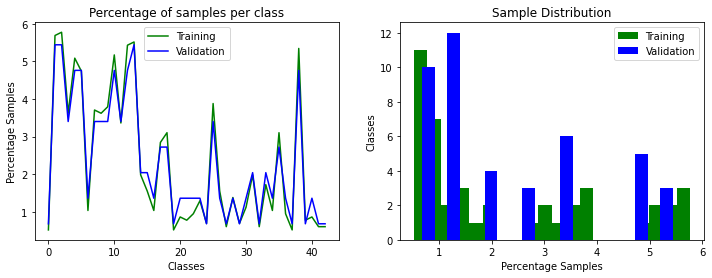

In [20]:
def plot_dataset_distributions(datasets, descs):
  fig, (ax0, ax1) = plt.subplots(ncols = 2, figsize = (12, 4))
  data_bin_list = []
  c = {0 : 'g', 1 : 'b'}
  c_idx = 0

  for dataset, desc in zip(datasets, descs):
    # Create Histograms of classes
    data_bins = np.bincount(dataset)

    # Convert to Percent
    data_bins = data_bins / len(dataset) * 100
    data_bin_list.append(data_bins)

    print("Dataset {} contains {} samples".format(desc, len(dataset)))
    print("Mean = {:.2f}% Median = {:.2f}%".format(mean(data_bins), median(data_bins)))

    ax0.plot(range(len(data_bins)), data_bins, label = desc, color = c[c_idx])
    ax0.set_title("Percentage of samples per class")
    ax0.set_xlabel("Classes")
    ax0.set_ylabel("Percentage Samples")
    ax0.legend()

    ax1.hist(data_bins, bins = 20, label = desc, color = c[c_idx])
    ax1.set_title("Sample Distribution")
    ax1.set_xlabel("Percentage Samples")
    ax1.set_ylabel("Classes")
    ax1.legend()
    c_idx += 1
  plt.show()
  
  return data_bin_list

y_hist = plot_dataset_distributions(datasets = [y_train, y_val], descs = ["Training", "Validation"])
y_train_hist = y_hist[0]
y_val_hist = y_hist[1]

Ratio : Mean = 1.11 Median = 1.01
Class  Train  Validation  Ratio
-----  -----  ----------  ------
0      0.52%     0.68%     1.32%
1      5.69%     5.44%     0.96%
2      5.78%     5.44%     0.94%
3      3.62%     3.40%     0.94%
4      5.09%     4.76%     0.94%
5      4.74%     4.76%     1.00%
6      1.03%     1.36%     1.32%
7      3.71%     3.40%     0.92%
8      3.62%     3.40%     0.94%
9      3.79%     3.40%     0.90%
10      5.17%     4.76%     0.92%
11      3.36%     3.40%     1.01%
12      5.43%     4.76%     0.88%
13      5.52%     5.44%     0.99%
14      1.98%     2.04%     1.03%
15      1.55%     2.04%     1.32%
16      1.03%     1.36%     1.32%
17      2.84%     2.72%     0.96%
18      3.10%     2.72%     0.88%
19      0.52%     0.68%     1.32%
20      0.86%     1.36%     1.58%
21      0.78%     1.36%     1.75%
22      0.95%     1.36%     1.43%
23      1.29%     1.36%     1.05%
24      0.69%     0.68%     0.99%
25      3.88%     3.40%     0.88%
26      1.55%     1.36%    

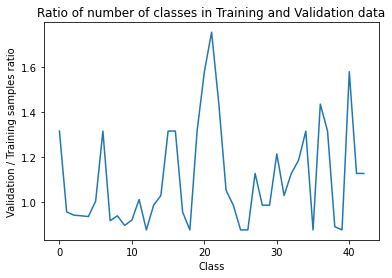

In [21]:
ratio = y_val_hist / y_train_hist
print("Ratio : Mean = {:.2f} Median = {:.2f}".format(mean(ratio), median(ratio)))

print("Class  Train  Validation  Ratio")
print("-----  -----  ----------  ------")

for i in range(n_classes):
  print("{} {:9.2f}%  {:7.2f}%  {:7.2f}%".format(i, y_train_hist[i], y_val_hist[i], ratio[i]))

plt.plot(range(n_classes), ratio)
plt.title("Ratio of number of classes in Training and Validation data")
plt.xlabel("Class")
plt.ylabel("Validation / Training samples ratio")
plt.show()

### Image Processing

In [0]:
# Converts RGB Images into Grayscale images
def rgb2gray(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img

In [0]:
# Contrast Limited Adaptive Histogram Equalization (CLAHE)
def clahe(img):
  clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
  img = clahe.apply(img)
  return img

In [0]:
# Normalizing the pixel values to be under 0 - 1
def normalize(img):
  img = img / 255
  return img

In [0]:
# Combining all the preprocessing functions
def preprocess(img):
  img = rgb2gray(img)
  img = clahe(img)
  img = normalize(img)
  return img

In [0]:
# Mapping the preprocess funtion to the dataset
x_train = np.array(list(map(preprocess, x_train)))
x_val = np.array(list(map(preprocess, x_val)))
x_test = np.array(list(map(preprocess, x_test)))

In [27]:
# Reshaping the dataset to have Rank 4 to be fit into the image data generator
x_train = x_train.reshape(-1, 32, 32, 1)
x_val = x_val.reshape(-1, 32, 32, 1)
x_test = x_test.reshape(-1, 32, 32, 1)

print("X_Train Shape = ", x_train.shape)
print("X_Val Shape = ", x_val.shape)
print("X_Test Shape = ", x_test.shape)

X_Train Shape =  (34799, 32, 32, 1)
X_Val Shape =  (4410, 32, 32, 1)
X_Test Shape =  (12630, 32, 32, 1)


In [0]:
# One - Hot Encoding Labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

### CNN Model

In [0]:
# CNN Model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 5, padding = "Same", activation = "relu", input_shape = (32, 32, 1)))
model.add(Conv2D(filters = 64, kernel_size = 5, padding = "Same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 128, kernel_size = 5, padding = "Same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = 5, padding = "Same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 64, kernel_size = 5, padding = "Same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = 64, activation = "relu"))
model.add(Dense(units = 43, activation = "softmax"))

In [0]:
# Optimizer
optimizer = Adam(lr = 0.001)

In [0]:
# Compliling the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

### Data Augmentation

In [0]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range = 10.0, width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.1, zoom_range = 0.2)
datagen.fit(x_train)

In [0]:
# Callbacks

# CSV Logger
csv_logger = CSVLogger("training.csv")

# Reduce LR On Plateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, verbose = 1, patience = 3, min_lr = 1e-4)

# Tensorboard
tensorboard = TensorBoard(log_dir = "logs")

### Training

In [34]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = 32), steps_per_epoch = 2048, epochs = 10,
                              validation_data = (x_val, y_val), callbacks = [reduce_lr, csv_logger, tensorboard])

Epoch 1/10
2048/2048 [==============================] - 40s 19ms/step - loss: 1.2029 - accuracy: 0.6353 - val_loss: 0.1246 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 2/10
2048/2048 [==============================] - 39s 19ms/step - loss: 0.2437 - accuracy: 0.9252 - val_loss: 0.0916 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 3/10
2048/2048 [==============================] - 39s 19ms/step - loss: 0.1648 - accuracy: 0.9507 - val_loss: 0.0360 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 4/10
2048/2048 [==============================] - 39s 19ms/step - loss: 0.1392 - accuracy: 0.9592 - val_loss: 0.0366 - val_accuracy: 0.9909 - lr: 0.0010
Epoch 5/10
2048/2048 [==============================] - 39s 19ms/step - loss: 0.1250 - accuracy: 0.9642 - val_loss: 0.0381 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 6/10
2048/2048 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9690
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2048/2048 [===============

### Tensorboard

In [36]:
# Viewing Tensorboard instances
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir logs (started 0:02:17 ago; pid 1451)


In [37]:
# Displaying Tensorboard
notebook.display(port = 6006, height = 1000)

Selecting TensorBoard with logdir logs (started 0:03:04 ago; port 6006, pid 1451).


<IPython.core.display.Javascript object>

In [0]:
# Tensorboard Visualization
# This command can also be used
# %tensorboard --logdir logs

### Evaluating Training

ERROR! Session/line number was not unique in database. History logging moved to new session 64


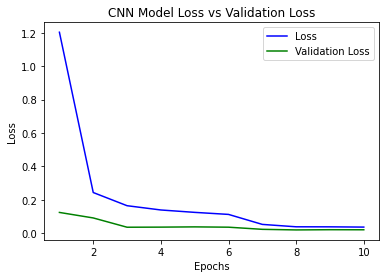

In [39]:
plt.plot(range(1, 11), history.history["loss"], label = "Loss", color = "b")
plt.plot(range(1, 11), history.history["val_loss"], label = "Validation Loss", color = "g")
plt.title("CNN Model Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 65


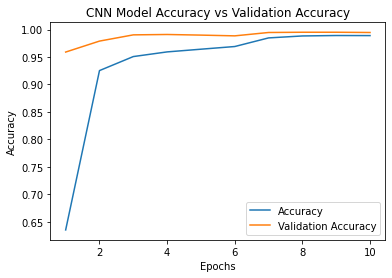

In [40]:
plt.plot(range(1, 11), history.history["accuracy"], label = "Accuracy")
plt.plot(range(1, 11), history.history["val_accuracy"], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Model Accuracy vs Validation Accuracy")
plt.legend()
plt.show()

### Evaluating the model on test data

In [0]:
# Evaluating the Peformance of the model
score = model.evaluate(x_test, y_test, verbose = 0)

In [44]:
# Scores
print("Model Test Loss = {:.4f}".format(score[0]))
print("Model Test Accuracy = {:.2f}%".format(score[1] * 100))

Model Test Loss = 0.0646
Model Test Accuracy = 98.37%


### Testing the CNN model

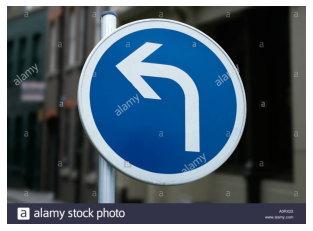

In [82]:
# Predicting Images from the internet

# Importing the required modules
import requests
from PIL import Image

# Try to load jpg or png images
# Try to take images within the classes in which the model is trained for use(data.values) to find out
url = "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"
r = requests.get(url, stream = True)

img = Image.open(r.raw)
plt.imshow(img)
plt.axis("off")
plt.show()

Image Shape before preprocessing =  (946, 1300, 3)
Image Shape after preprocessing =  (32, 32)


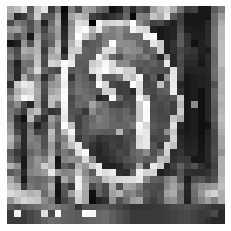

In [83]:
img = np.asarray(img)
print("Image Shape before preprocessing = ", img.shape)

img = cv2.resize(img, (32, 32))
img = preprocess(img)
print("Image Shape after preprocessing = ", img.shape)

plt.imshow(img, cmap = "gray")
plt.axis("off")
plt.show()

In [84]:
# Image is reshaped to add batch dimension and channel dimension
img = img.reshape(1, 32, 32, 1)
print("Predicted Sign = ", data.values[model.predict_classes(img)[0]][1])

Predicted Sign =  Turn left ahead


### Serializing the CNN Model and Saving it's Weights

In [85]:
# Serializing Model to Json
model_json = model.to_json()
with open("model.json", mode = "w") as json_file:
  json_file.write(model_json)

print("Saved Model as JSON File")

Saved Model as JSON File


### Loading Serialized Model and Weights

In [90]:
# Loading JSON File
with open("model.json", mode = "r") as json_file:
  loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

print("Loaded JSON Model")

Loaded JSON Model


In [92]:
# Loaded JSON Model
print(loaded_model_json)

{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "batch_input_shape": [null, 32, 32, 1], "dtype": "float32", "filters": 32, "kernel_size": [5, 5], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [5, 5], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": nu

In [88]:
# Saving Model weights as h5 file
model.save_weights("model.h5")
print("Saved Model Weights")

Saved Model Weights


In [93]:
# Loading Model Weights into Loaded JSON Model
loaded_model.load_weights("model.h5")
print("Loaded Model from Disk")

Loaded Model from Disk


### Evaluating Loaded Model on Test Data

In [96]:
# Evaluating the Peformance of the Loaded model
score = model.evaluate(x_test, y_test, verbose = 0)

print("Loaded Model Test Loss = {:.4f}".format(score[0]))
print("Loaded Model Test Accuracy = {:.2f}".format(score[1] * 100))

Loaded Model Test Loss = 0.0646
Loaded Model Test Accuracy = 98.37
